# Model selection
Once we have prepared our data, we can start to think about how to choose the best model for our problem. We will look at the following topics:
- Feature selection by correlation;
- Cross-validation;
- Fine-tuning the lightgbm model;

# Importing the libraries

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping
import pyproj
import pandas as pd
import sklearn as skl
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib.widgets import Cursor
from matplotlib import animation
import datetime
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Importing the dataset

In [58]:
# Create a path to the data directory
path_data = "../dataframe/"

In [72]:
# open the csv file with the data
df = pd.read_csv(path_data + "df_final.csv", parse_dates=["time"])



In order to let the model learn from the period of the year, we need to convert the date to a number. We will use the month and the quarter of the year, which is respectivally a number between 1 to 12 and 1 to 4.  

In [73]:
# add a column for the month
df["month"] = df["time"].dt.month
# add a column for the trimester
df["trimester"] = df["time"].dt.quarter

,x,month,y,time,density,First_Day,Last_Day,Burn_Date,FireMask,ET_500m_mean,Fpar_500m_mean,u10_mean,v10_mean,t2m_mean,tp_mean,LST_Day_1km_mean,LST_Night_1km_mean,_1_km_16_days_EVI_mean
0,4.297939,8,43.866081,2010-08-25,112.735565,215.0,284.145161,0.0,1.0,13.119998,0.589453,0.493079,-0.398500,294.267860,0.000495,308.146037,291.400300,0.314512
1,4.297939,8,43.866081,2010-08-26,112.735565,216.0,285.088710,0.0,1.0,12.699999,0.590332,0.382728,-0.298730,294.779242,0.000475,308.888037,291.706507,0.313087
2,4.297939,8,43.866081,2010-08-27,112.735565,217.0,286.032258,0.0,1.0,12.699999,0.591215,0.113627,-0.095291,295.280672,0.000475,308.796037,291.946219,0.311662
3,4.297939,8,43.866081,2010-08-28,112.735565,218.0,286.975806,0.0,1.0,12.699999,0.592102,0.286204,-0.304005,295.701109,0.000477,308.466037,292.025526,0.310237
4,4.297939,8,43.866081,2010-08-29,112.735565,219.0,287.919355,0.0,1.0,12.699999,0.592992,0.291617,-0.842304,295.593359,0.000477,308.180563,291.855095,0.308812


# Correlation matrix
A correlation matrix is simply a table which displays the correlation coefficients for different variables. The matrix depicts the correlation between all the possible pairs of values in a table. It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.

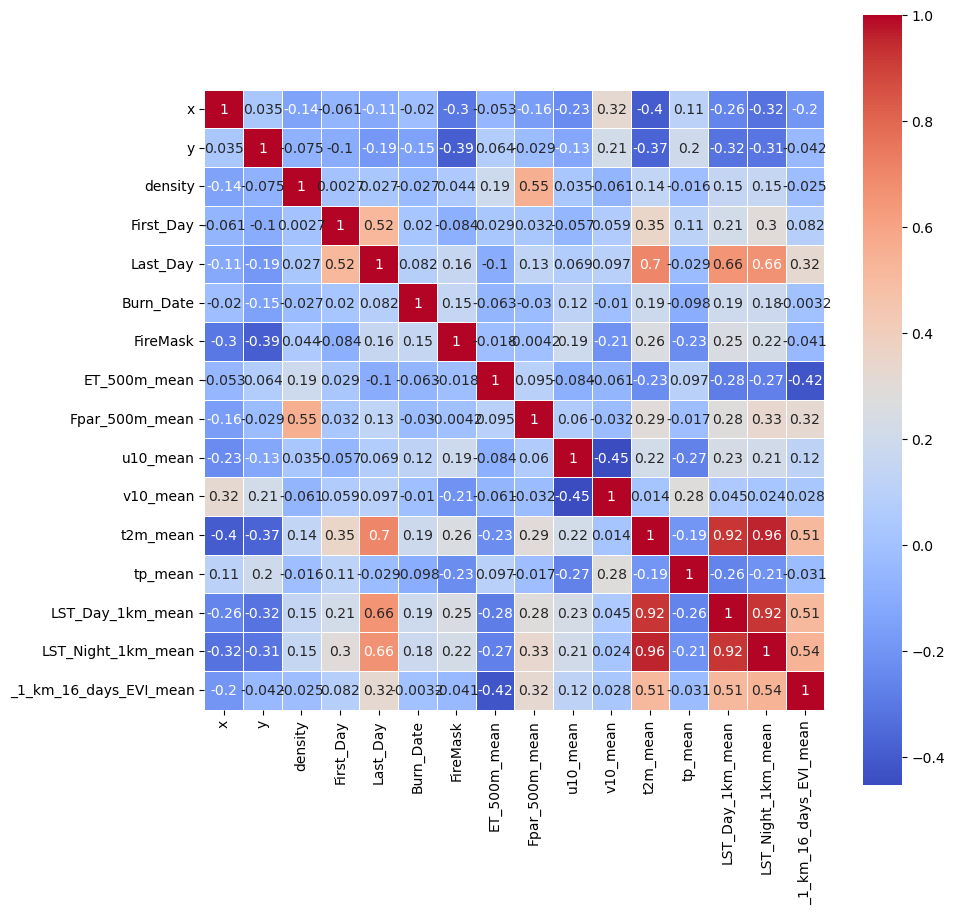

In [61]:
# define a function to get the correlation matrix and plot it
def get_correlation_matrix(the_df):
    """
    This function returns the correlation matrix of the dataframe
    input:
        the_df: the dataframe
    output:
        the correlation matrix
    """
    # Correlation matrix : 
    cor = the_df.corr() 
    plt.figure(figsize=(15, 15))
    sns.heatmap(cor, square = True, cmap="coolwarm", linewidths=0.5, annot=True, xticklabels='auto', yticklabels='auto',)
        
    return cor

# get the correlation matrix
cor = get_correlation_matrix(df)



As we can see, the correlation between the variables is not very high. The highest correlation is between the month and the quarter, which is normal. The correlation between the target variable and the other variables is also not very high. This means that we will not be able to predict the target variable very well with a simple linear model. We will need to use a more complex model.

# Cross Validation
In cross-validation, the data is split into a training set and a test set. The model is trained on the training set and evaluated on the test set. The evaluation metric is then computed on the test set. The process is repeated for several complementary partitions and the evaluation metric is averaged over the different folds. This process is called k-fold cross-validation. The data is split into k folds, and the process is repeated k times. Each time, one fold of the data is used as the test set for evaluating the model, and the remaining k − 1 folds are used as training set. The final result is then the average of the values computed in the loop. The advantage of cross-validation is that all observations are used for both training and validation, and each observation is used for validation exactly once. The disadvantage is that k-fold cross-validation is computationally more expensive than leave-one-out cross-validation.

The following models will be used:
- Linear regression;
- k-nearest neighbors;
- Random forest;
- Xgboost;
- Lightgbm.

Linear regression is a linear approach for modeling the relationship between a scalar response and one or more explanatory variables. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression. Linear regression fits a linear model to the data set. The best-fit line is called the regression line. The linear regression model is a linear approach for modeling the relationship between a scalar response and one or more explanatory variables. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression. Linear regression fits a linear model to the data set. The best-fit line is called the regression line.

K-nearest neighbors is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression. In classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common. In regression, the output is the property value for the object. This value is the average of the values of its k nearest neighbors.

Random forest is a supervised learning algorithm. It can be used both for classification and regression problems, but mostly it is preferred for solving classification problems. For solving regression problems, random forest uses mean of the outputs of the individual trees. Random forest is a supervised learning algorithm. It can be used both for classification and regression problems, but mostly it is preferred for solving classification problems. For solving regression problems, random forest uses mean of the outputs of the individual trees.

Xgboost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. Xgboost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

Lightgbm is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages: Faster training speed and higher efficiency; Lower memory usage; Better accuracy; Support of parallel and GPU learning; Capable of handling large-scale data.




In [77]:
# First, define the models we want to use
# We use the same random state for each model to be able to compare them
# We use the class_weight parameter to balance the classes
# We use the max_iter parameter to avoid convergence warnings
# We use the n_estimators parameter to avoid convergence warnings
# We use the max_depth parameter to avoid convergence warnings
# We use the l1_ratio parameter to avoid convergence warnings
# We use the eval_metric to logloss for classification

# Download the libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Linear regression, k nearest neighbors, random forest, xgboost, lightgbm 
model_LR = skl.linear_model.LogisticRegression(C=0.05, l1_ratio=None, max_iter=10000)
model_KNN = skl.neighbors.KNeighborsClassifier()
model_RF = skl.ensemble.RandomForestClassifier(n_estimators=100, max_depth=2)
model_XGB = XGBClassifier(n_estimators=100, max_depth=2, use_label_encoder=False, eval_metric='logloss')
model_LGBM = LGBMClassifier(n_estimators=100, max_depth=2)

# put all those models in a list
models = [model_LR, model_KNN, model_RF, model_XGB, model_LGBM]



The following code is used to evaluate the models. The function cross_validation returns the mean of the evaluation metric for the different folds. We will do a 10-fold cross-validation and we will compare the results of the different models in the case of stratified k-fold cross-validation and in the case of k-fold cross-validation with shuffling or not.

In [ ]:
# Download the libraries for the cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# define a function to perform cross validation for the given models
def cross_validation(models, the_df, n_splits=10, random_state=71, stratified=True, shuffle=True):
    """
    This function performs cross validation for the given models
    input:
        models: the models to be evaluated
        X: the features
        y: the target
        n_splits: the number of splits
        random_state: the random state
    output:
        a dataframe with the results
    """
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
    # Create conditional statement to check if stratified or not
    if stratified:
        # create a stratified k-fold object
        if shuffle:
            kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        else:
            kf = StratifiedKFold(n_splits=n_splits, shuffle=False)
    else:
        # create a non stratified k-fold object
        if shuffle:
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        else:
            kf = KFold(n_splits=n_splits, shuffle=False) 
    # Define target and features
    X = the_df.drop(['time','FireMask'], axis=1)
    y = the_df['FireMask'].astype(int)
    # loop over the folds
    for train_index, test_index in kf.split(X, y):
        # split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # loop over the models
        for model in models:
            # fit the model
            time_0 = datetime.datetime.now()
            model.fit(X_train, np.ravel(y_train))
            time_1 = datetime.datetime.now()
            # predict the target
            y_pred = model.predict(X_test)
            # compute the accuracy
            accuracy = accuracy_score(y_test, y_pred)
            # compute the precision
            precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
            # compute the recall
            recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
            # compute the f1 score
            f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
            # compute the time to fit the model in seconds
            time_fit = (time_1 - time_0).total_seconds()

            # store the results in the dataframe sorted by accuracy
            results = results.append({'model': model.__class__.__name__,
                                      'accuracy': accuracy,
                                      'precision': precision,
                                      'recall': recall,
                                      'f1': f1,
                                      'Time to fit': time_fit}, ignore_index=True)

            # group the results by model
            results = results.groupby('model').mean().reset_index().sort_values(by='accuracy',
                             ascending=False).reset_index(drop=True)

    # return the dataframe
    return results



In [ ]:
# Run the cross validation for the models in the for combinatotions of stratified and shuffle and retarn a 2x2 matrix of results
# stratified = True, shuffle = True
results_stratified_shuffle = cross_validation(models, df, n_splits=10, random_state=71, stratified=True, shuffle=True)
# stratified = True, shuffle = False
results_stratified_noshuffle = cross_validation(models, df, n_splits=10, random_state=71, stratified=True, shuffle=False)
# stratified = False, shuffle = True
results_nostatified_shuffle = cross_validation(models, df, n_splits=10, random_state=71, stratified=False, shuffle=True)
# stratified = False, shuffle = False
results_nostatified_noshuffle = cross_validation(models, df, n_splits=10, random_state=71, stratified=False, shuffle=False)


In [95]:
results_stratified_shuffle

,model,accuracy,precision,recall,f1,Time to fit
0,XGBClassifier,0.861313,0.839473,0.893503,0.865630,1.836835
1,KNeighborsClassifier,0.850197,0.794085,0.945663,0.863261,0.005802
2,LGBMClassifier,0.827266,0.814214,0.848065,0.830783,0.186438
3,RandomForestClassifier,0.766673,0.761094,0.777577,0.769178,1.840203
4,LogisticRegression,0.716461,0.723997,0.700059,0.711745,5.793460


In [96]:
results_nostatified_shuffle

,model,accuracy,precision,recall,f1,Time to fit
0,XGBClassifier,0.861240,0.843865,0.887642,0.865190,1.692548
1,KNeighborsClassifier,0.854621,0.801343,0.944383,0.866981,0.005912
2,LGBMClassifier,0.828301,0.817776,0.846367,0.831806,0.174040
3,RandomForestClassifier,0.767954,0.756428,0.792751,0.774141,1.886625
4,LogisticRegression,0.719863,0.726867,0.707498,0.717006,8.168994


In [97]:
results_stratified_noshuffle

,model,accuracy,precision,recall,f1,Time to fit
0,LGBMClassifier,0.781175,0.793826,0.759040,0.775683,0.193883
1,XGBClassifier,0.777256,0.808440,0.726541,0.765081,1.932487
2,KNeighborsClassifier,0.675865,0.705865,0.600902,0.648416,0.003994
3,RandomForestClassifier,0.671160,0.689604,0.607046,0.641899,2.102548
4,LogisticRegression,0.646176,0.678327,0.542000,0.594726,6.831260


In [98]:
results_nostatified_noshuffle

,model,accuracy,precision,recall,f1,Time to fit
0,XGBClassifier,0.796127,0.744787,0.771613,0.750119,1.894637
1,LGBMClassifier,0.783507,0.721791,0.793563,0.745360,0.222530
2,RandomForestClassifier,0.702974,0.648328,0.685848,0.649780,2.009390
3,KNeighborsClassifier,0.684819,0.625730,0.610797,0.608583,0.005817
4,LogisticRegression,0.666104,0.604055,0.584955,0.582646,6.966763


The results are better in the case of stratified k-fold cross-validation and in the case of k-fold cross-validation with shuffling. The results are better in the case of stratified k-fold cross-validation because the classes are balanced in the different folds. The results are better in the case of k-fold cross-validation with shuffling because the data is shuffled before the split into folds. This means that the data is not ordered by date. The data is ordered by date because we have converted the date to a number. This means that the model will learn from the period of the year. If we shuffle the data, the model will not learn from the period of the year.
As we can see, even if the best model is the XGBClassifier that gives slighty better metrics than LightGBM, this one takes significant less time to train. We will therefore use the LightGBM model. We will now fine-tune the model.

# Fitting the lightgbm model
After the previous chapter, we have a model that is ready to be used. We will split the dataset into a training set and a test set based on the date. The training set will contain the data from 2013 to 2017 and the test set will contain the data from 2018. We will use the lightgbm model to predict the target variable in the test set. We will then compare the predictions with the actual values. We will also compute the evaluation metric.


In [135]:
# Split the data into train and test
df_train = df[df["time"] < "2018-01-01"]
df_test = df[df["time"] >= "2018-01-01"]


In [136]:
# Define the function to fit the model
def fit_lgbm_model(the_df_train, n_estimators=100, max_depth=2):
    """
    This function fits a lgmb model
    input:
        the_df_train: the dataframe
        n_estimators: the number of estimators
        max_depth: the maximum depth
        path_data: the path where to save the pickle file
    output:
        the model
    """
    # define the model
    model = LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth)
    # define the features and the target
    X_train = the_df_train.drop(['time','FireMask'], axis=1)
    y_train = the_df_train['FireMask'].astype(int)
    # fit the model
    time_start = datetime.datetime.now()
    model.fit(X_train, y_train)
    time_end = datetime.datetime.now()
    # Add the time as model attribute
    model.time = (time_end - time_start).total_seconds()

    # return the model
    return model

lgbm_model = fit_lgbm_model(df_train, n_estimators=100, max_depth=2)

In [ ]:
# generate the pickle file
pickle.dump(lgbm_model, open('model_lgbm.pkl', 'wb'))

In [137]:
# Define the function to predict the target
def predict_lgbm_model(the_df_test, model):
    """
    This function predicts the lgbm model
    input:
        the_df_test: the tet dataframe
        model: the model
    output:
        the predictions
    """
    # define the features
    X_test = the_df_test.drop(['time','FireMask'], axis=1)
    # predict the model
    y_pred = model.predict(X_test)
    # give the perobabilities of the predictions
    y_pred_proba = model.predict_proba(X_test)
    
    # Stack the prediction with the time and target
    the_df_pred = pd.DataFrame({"time":the_df_test["time"], "FireMask": the_df_test["FireMask"].astype(int),
                                "FireMask_pred": y_pred, "FireMask_proba": y_pred_proba[:, 1]})
    
    # return the the dataframe
    return the_df_pred

df_pred = predict_lgbm_model(df_test, lgbm_model)
df_pred

,time,FireMask,FireMask_pred,FireMask_proba
22558,2018-08-17,1,0,0.299340
22559,2018-08-18,1,0,0.299340
22560,2018-08-19,1,0,0.299340
22561,2018-08-20,1,0,0.315055
22562,2018-08-21,1,0,0.315055
...,...,...,...,...
29177,2020-11-09,0,0,0.148010
29178,2020-05-16,0,0,0.201505
29179,2020-02-13,0,1,0.658058
29180,2020-02-05,0,0,0.265288


In [140]:
# import the libraries

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# define a function to plot accuracy, precision, recall, f1-score and time to fit
def plot_metrics(model, y_test, y_pred):
    """
    This function plots the accuracy, precision, recall, f1-score
    input:
        y_test: the test target
        y_pred: the predictions
    output:
        None
    """
    results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
    # compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # plot the metrics
    results = results.append({'model': model.__class__.__name__,
                                      'accuracy': accuracy,
                                      'precision': precision,
                                      'recall': recall,
                                      'f1': f1,
                                      'time to fit [s]': model.time
                                      }, ignore_index=True)
    return results

resultas = plot_metrics(lgbm_model, df_pred['FireMask'], df_pred['FireMask_pred'].astype(int))
resultas

,model,accuracy,precision,recall,f1,time to fit [s]
0,LGBMClassifier,0.783967,0.808664,0.743961,0.774965,0.151995


In [138]:
# reset the index
df_pred.reset_index(inplace=True, drop=False)
df_test.reset_index(inplace=True, drop=False)

# drop time and FireMask from the pred dataframe
df_pred.drop(['time','FireMask'], axis=1, inplace=True)

# merge the pred dataframe with the test dataframe
df_model = pd.merge(df_test, df_pred, on='index', how='left')
df_model.head()



,index,x,month,y,time,density,First_Day,Last_Day,Burn_Date,FireMask,...,Fpar_500m_mean,u10_mean,v10_mean,t2m_mean,tp_mean,LST_Day_1km_mean,LST_Night_1km_mean,_1_km_16_days_EVI_mean,FireMask_pred,FireMask_proba
0,22558,4.337576,8,44.430909,2018-08-17,65.063034,207.411290,279.903226,0.0,1.0,...,0.584072,0.419922,-1.000133,293.199289,0.004510,301.407863,289.563687,0.380487,0,0.299340
1,22559,4.337576,8,44.430909,2018-08-18,65.063034,208.483871,280.709677,0.0,1.0,...,0.585918,0.456385,-1.454020,292.898217,0.004733,301.139173,289.720516,0.382837,0,0.299340
2,22560,4.337576,8,44.430909,2018-08-19,65.063034,209.556452,281.516129,0.0,1.0,...,0.587551,0.431329,-1.913773,292.856045,0.004273,301.387495,290.000703,0.385432,0,0.299340
3,22561,4.337576,8,44.430909,2018-08-20,65.063034,210.629032,282.322581,0.0,1.0,...,0.588971,0.459216,-1.988419,293.172901,0.001606,301.535495,290.404703,0.388272,0,0.315055
4,22562,4.337576,8,44.430909,2018-08-21,65.063034,211.701613,283.129032,0.0,1.0,...,0.590178,0.499901,-2.060565,293.591260,0.001606,301.630000,290.748497,0.391357,0,0.315055


In [139]:
# save the dataframe to csv
df_model.to_csv("df_model.csv", index=False)